In [255]:
# when importing the new dataset, compare this one with median prices to the zillow estimate 

In [256]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm 

from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [257]:
def stationarity_check(df):
    
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12,center=False).std()
    
    dftest = adfuller(df)
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean and std')
    plt.show(block=False)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#lags used', 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)

In [258]:
"""
Grid search for best pdq value based on aic 
return two tuples containing optimal pdq and pdqs values for fitting in SARIMAX model 
"""
def get_pdqs_aic(df, seasonal=12, display=True):   

    # p d and q can be 0, 1 or 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p (autogressive terms), d (differencing), and q (moving average terms)
    pdq = list(itertools.product(p, d, q))
    
    # do the same with seasonal 
    # default 12: this data has a yearly seasonal component  
    pdqs = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

    # Takes the permutations above and runs a grid search to find the model with the lowest AIC score 
    output = []
    for combo in pdq:
        for combo_seasonal in pdqs:
            try:
                results = train_sarimax(df, pdq=combo, PDQS=combo_seasonal, summary=False)
                # TODO - test for RMSE and append 
                output.append([combo, combo_seasonal, results.aic])
                if display:
                    print(f'pdq: {combo}; pdqs: {combo_seasonal}, AIC: {output.aic}'))
            except:
                continue
            
    # Find the parameters with minimal AIC value
    output_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df

In [359]:
def train_sarimax(df, pdq=(0,2,2), PDQS=(0,0,0,12), summary=False):
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                                          enforce_stationarity=True, 
                                          enforce_invertibility=True)
    
    results = arima_mod.fit()
    
    if summary:
        print(results.summary())
    return results 

In [259]:
data = pd.read_csv('zillow_data.csv')

data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [260]:
print(f'{data.RegionName.nunique()} unique zip codes')

print('{} unique zip codes in NJ'.format(data[data.State == 'NJ'].RegionName.nunique()))

14723 unique zip codes
502 unique zip codes in NJ


In [261]:
nj = data[data.State == 'NJ']
nj.isna().sum()
# null_values = pd.DataFrame(nj.isna().sum(), columns=['sum']).sort_values(by='sum', ascending=False)
# null_values

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [262]:
melted = pd.melt(nj,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
len(melted) #502 zip codes in NJ and 1996 to 2018 
print(melted.isna().sum())
melted.head()

RegionName    0
RegionID      0
SizeRank      0
City          0
State         0
Metro         0
CountyName    0
time          0
value         0
dtype: int64


,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,7030,60545,58,Hoboken,NJ,New York,Hudson,1996-04-01,301600.0
1,8701,61148,74,Lakewood,NJ,New York,Ocean,1996-04-01,153800.0
2,8753,61169,159,Toms River,NJ,New York,Ocean,1996-04-01,123400.0
3,7002,60518,188,Bayonne,NJ,New York,Hudson,1996-04-01,145000.0
4,7302,60639,192,Jersey City,NJ,New York,Hudson,1996-04-01,137200.0


In [263]:
df = melted[['RegionName','time','value']].rename(columns={'RegionName':'zip','value':'median_price'}).set_index('time')
df.head()

,zip,median_price
time,,
1996-04-01,7030,301600.0
1996-04-01,8701,153800.0
1996-04-01,8753,123400.0
1996-04-01,7002,145000.0
1996-04-01,7302,137200.0


## Overall NJ Analysis 

In [270]:
nj_avg = df[['median_price']].groupby('time').median_price.median().reset_index().rename(columns={'median_price':'median_price'}).set_index('time')
nj_avg = nj_avg.asfreq('MS')
nj_avg

,median_price
time,
1996-04-01,156650.0
1996-05-01,156650.0
1996-06-01,156600.0
1996-07-01,156550.0
1996-08-01,156450.0
...,...
2017-12-01,331650.0
2018-01-01,333050.0
2018-02-01,334100.0


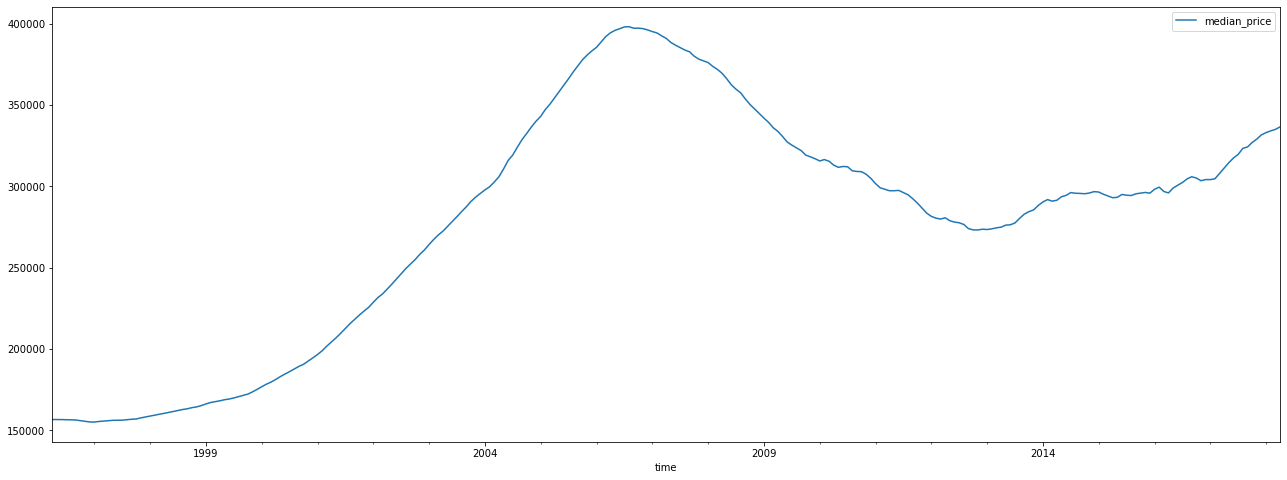

In [271]:
nj_avg.plot(figsize=(22,8))
# TODO add in minimums and lines for recession 
plt.show()

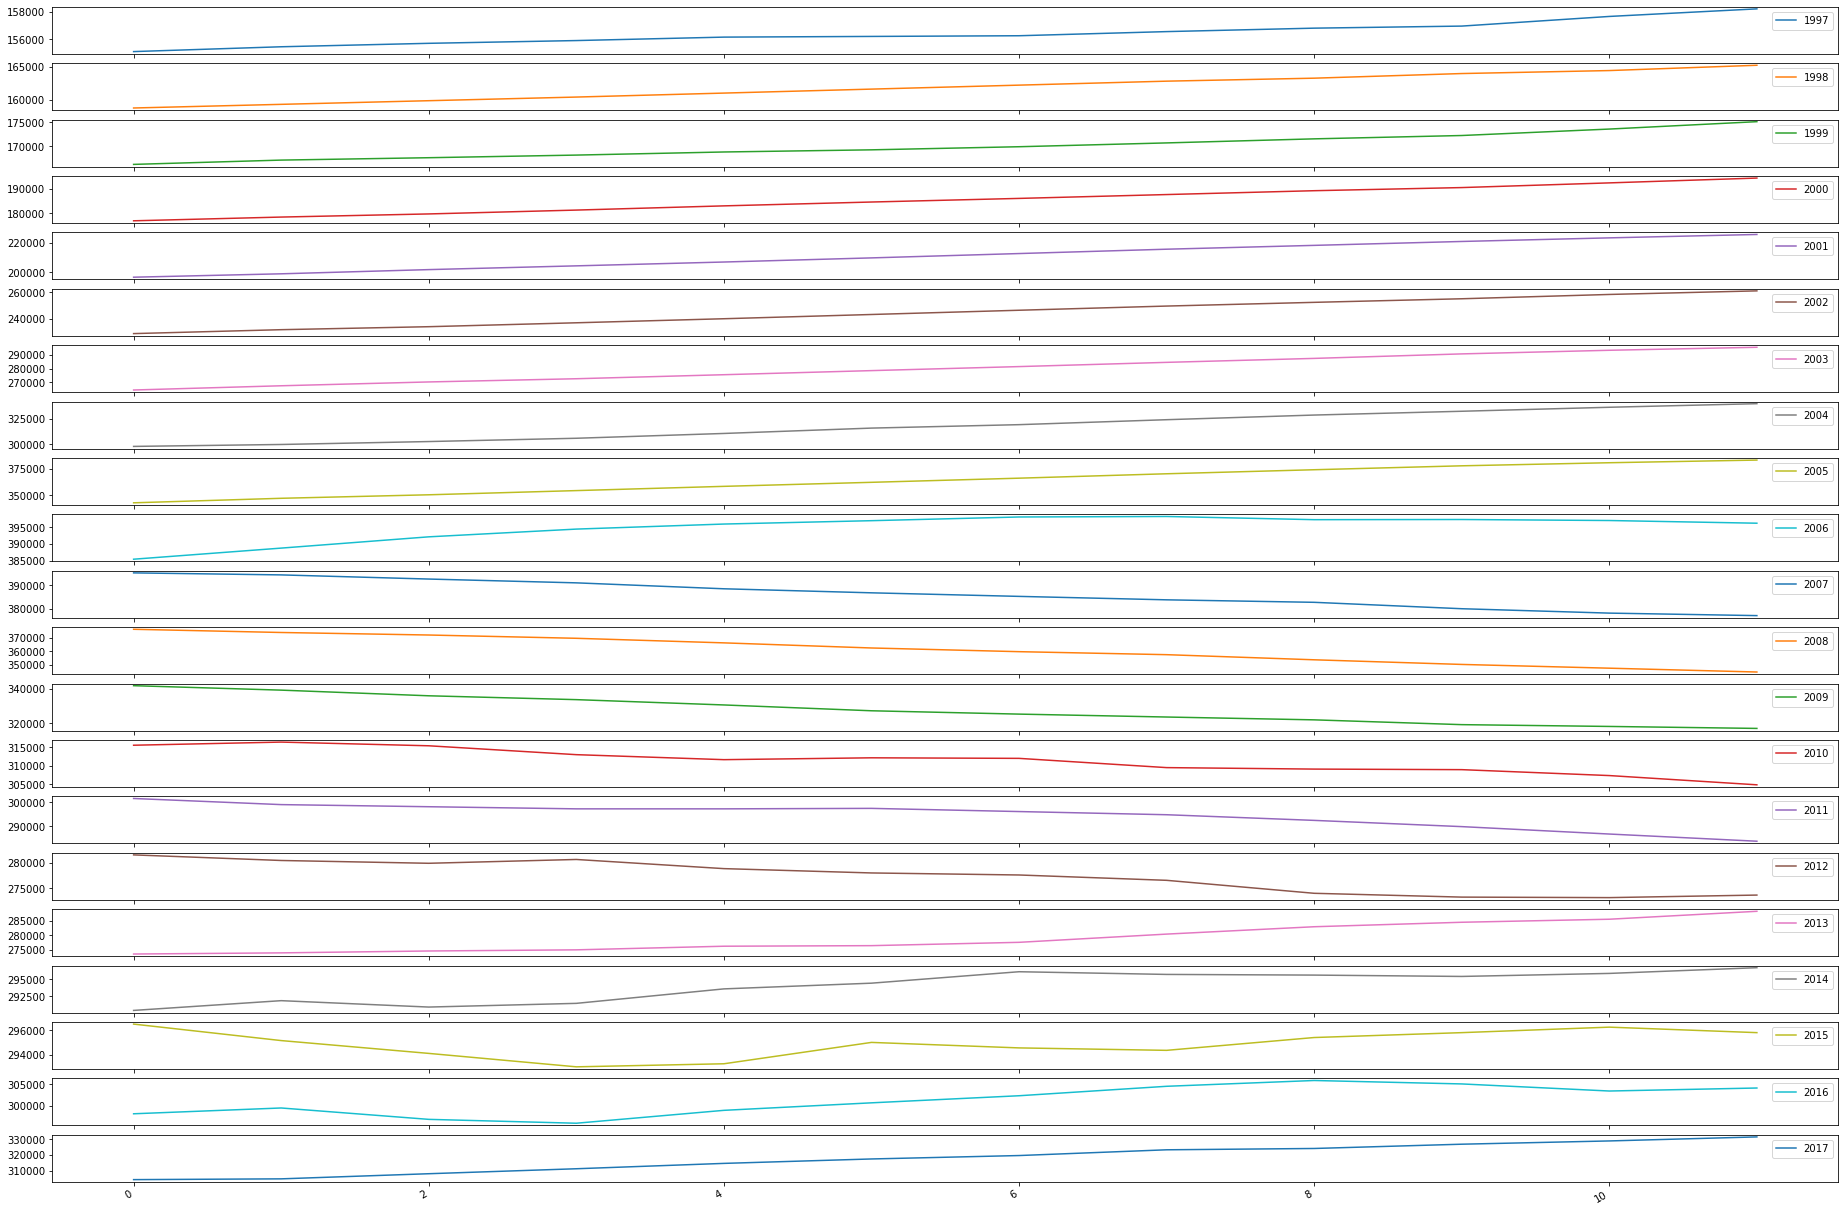

In [29]:
# not full years in 96 and 2018 
year_groups = nj_avg['1997':'2017'].groupby(pd.Grouper(freq='A'))
temp_annual = pd.DataFrame()
for yr, group in year_groups:
    temp_annual[yr.year] = group.values.ravel()
temp_annual.plot(figsize=(32,24),subplots=True, legend=True)
plt.show()

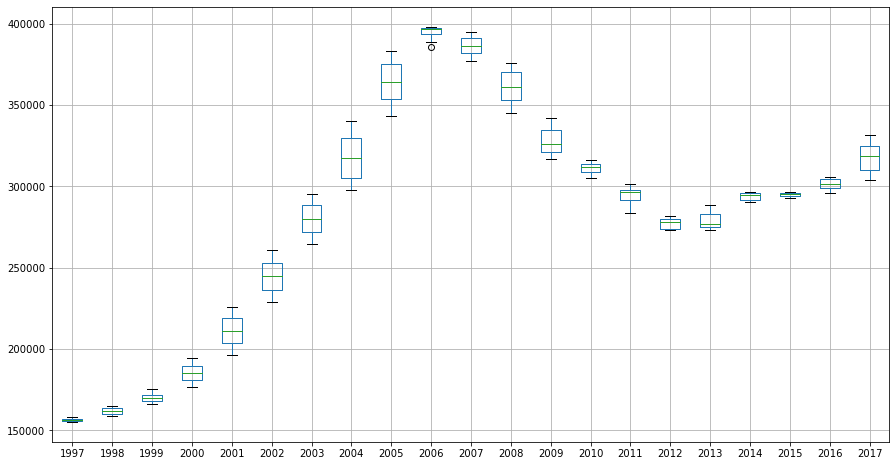

In [30]:
temp_annual.boxplot(figsize=(15,8))
plt.show()

In [ ]:
""" 
d=2 
p=1 
q=1 (slightly over differenced based on the immediate negative correlation for the acf plot)
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. 
Likewise, if it is slightly over-differenced, try adding an additional MA term.

"""

In [285]:
nj_avg_m = nj_avg.resample('MS').sum()
nj_avg_m = nj_avg_m['2012':]

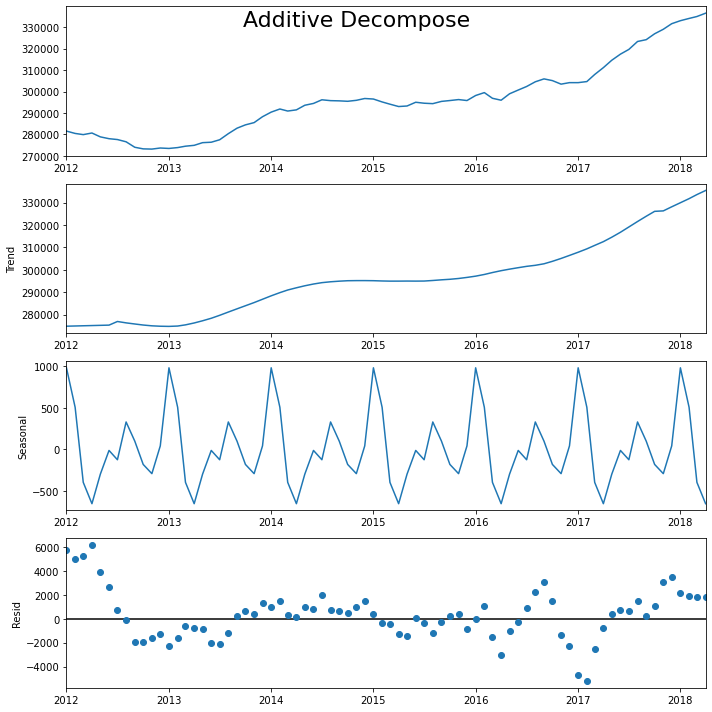

In [274]:
result_add = seasonal_decompose(nj_avg_m, model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

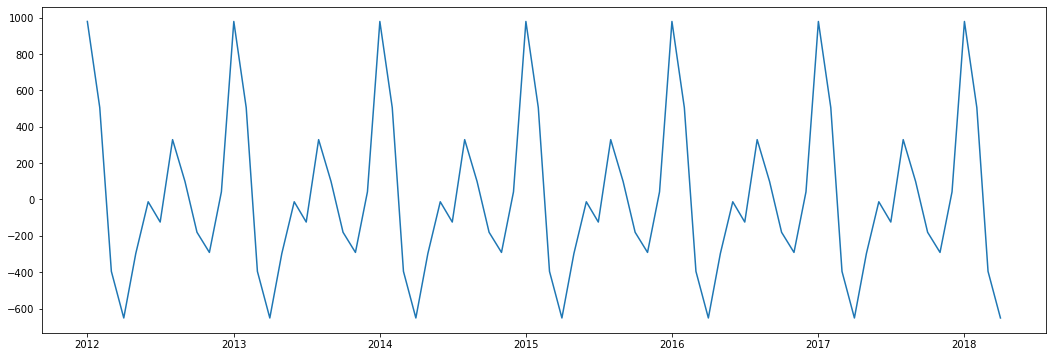

In [254]:
plt.figure(figsize=(18,6))
# TODO add dotted lines 
plt.plot(result_add.seasonal)
plt.show()

In [329]:
# get PDQS
get_pdqs_aic(nj_avg_m) # TODO - make this output pdq, and PDQ so it can be added to next method 

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2105.0061483537925
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =921708.4147944818
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1377.421874884586
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1125.2886489295709
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1354.3982404150704
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1325.6996542900429
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1137.1852117664919
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1117.595880030865
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =2026.2970156202316
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =840798.5527879102
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1379.8505169089785
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1081.0210344690174
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1736.9159306968065
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1684.795292305747
ARIMA (0, 0

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",2105.006148
1,"(0, 0, 0)","(0, 0, 1, 12)",921708.414794
2,"(0, 0, 0)","(0, 1, 0, 12)",1377.421875
3,"(0, 0, 0)","(0, 1, 1, 12)",1125.288649
4,"(0, 0, 0)","(1, 0, 0, 12)",1354.398240
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",879.101928
60,"(1, 1, 1)","(1, 0, 0, 12)",1071.543086
61,"(1, 1, 1)","(1, 0, 1, 12)",1057.112044
62,"(1, 1, 1)","(1, 1, 0, 12)",884.291740


In [424]:
# split into training and test data 

train = nj_avg_m.loc['2012':'2015-03-01']
test = nj_avg_m.loc['2015-04-01':]


In [ ]:
""" 
takes in string and splits data
date entered is included in the train data 
"""
def split_train_test(df, split='2015-03-01'):
    return df.loc[:split], df.loc[pd.to_datetime(split) + pd.DateOffset(months=1):]

In [ ]:
def train_results_rmse(results, train, period=24, display=True):
    # predict going back from 2 years, or other time specified 
    train_predict = results.predict(-period)
    
    # visualize results, plot train vs. predicted values 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        train.plot(ax=ax, label='train actual')
        # plot one step ahead predictions 
        train_predict.plot(ax=ax, style='r--', label='one step ahead forecast')
        legend=ax.legend(loc='lower right')

    rmse = np.sqrt(mean_squared_error(predict, train[-period:])) 
    print(f'RMSE: {rmse}')
    return rmse 

In [ ]:
# walk forward validation on test data 
# return RMSE 
def test_results_rmse(results, train, test, pdq=(1,1,1), PDQS=(1,1,1,12), display=True):
    # walk-forward validation
    predictions=[]
    history = [x for x in train.values]
    actuals = test.values

    for t in range(len(test)):
        results = train_sarimax(history, pdq=pdq, PDQS=PDQS, summary=False)
        output=results.forecast()
        y_hat = output[0]
        predictions.append(y_hat)
        actual = actuals[t]
        history.append(actual)
        #print('predicted: {}, expected: {}'.format(y_hat, actual))
    
    # convert predictions from list to series so rmse can be calculated 
    predictions = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f'Test RMSE: {rmse}')
    
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='predictions')
        legend=ax.legend(loc='lower right')
        plt.show()
    
    return rmse 

In [446]:
# dynamic predictions on test data using results 
# return RMSE 
def test_dynamic_predictions(results, test, display=True):
    # dynamic prediction 
    dynamic_pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=True)
    predictions = dynamic_pred.predicted_mean
    actuals = test.values 
    pred_ci = dynamic_pred.conf_int()
    
    # visualize test vs. dynamic predictions 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
    #     plt.plot(train['2014-01-01':], label='training')
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='dynamic forecast')
        ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
        plt.title('Test Dynamic Forecast vs. Test Actuals')
        legend=ax.legend(loc='lower right')
        plt.show()
    
    # get the rmse and return 
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f'RMSE: {rmse}')
    
    return rmse 

1844.9560444271078


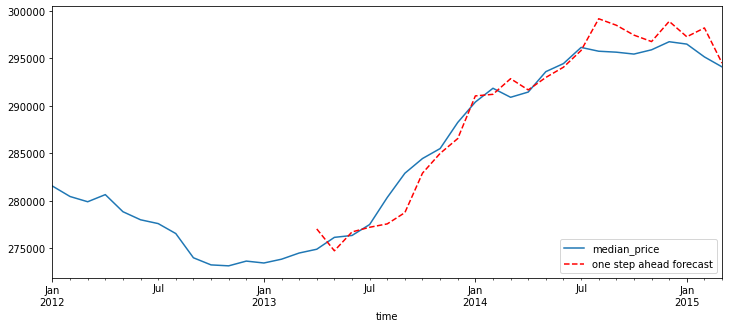

In [417]:
# model fitting 

results = train_sarimax(train, pdq=(1,1,1), PDQS=(1,1,1,12), summary=False)
predict=results.predict(-24)

fig,ax=plt.subplots(figsize=(12,5))
train['2012':].plot(ax=ax, label='actual')
# predict.predicted_mean.loc['2013':'2015-04-01'].plot(ax=ax, style='r--', label='one step ahead forecast')
predict.plot(ax=ax, style='r--', label='one step ahead forecast')

# predict_dy.predicted_mean.loc['2014-01-01':].plot(ax=ax,style='g', label='Dynamic Forecast')
legend=ax.legend(loc='lower right')

# print(np.sqrt(mean_squared_error(predict.predicted_mean['2012':], train['2012':])))
print(np.sqrt(mean_squared_error(predict, train[-(len(predict)):])))

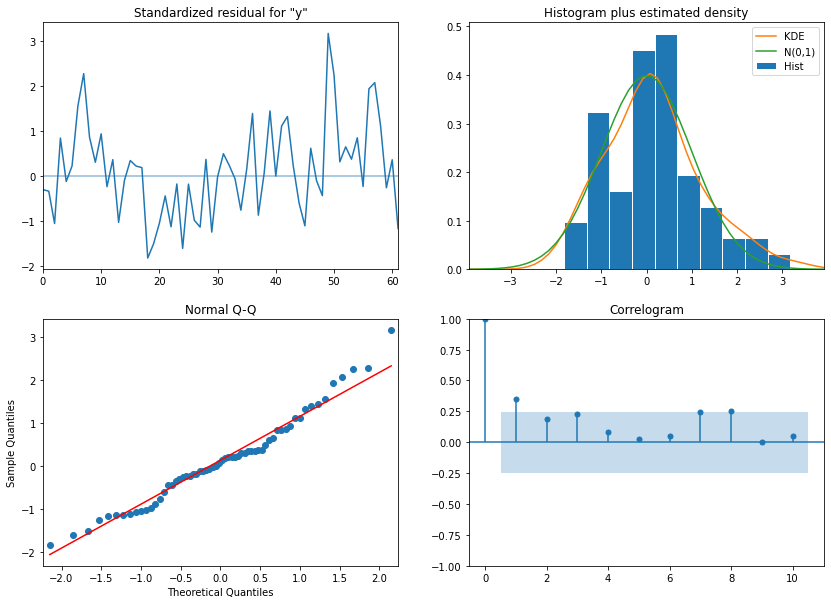

In [406]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

Test RMSE: 2017.4224986347815


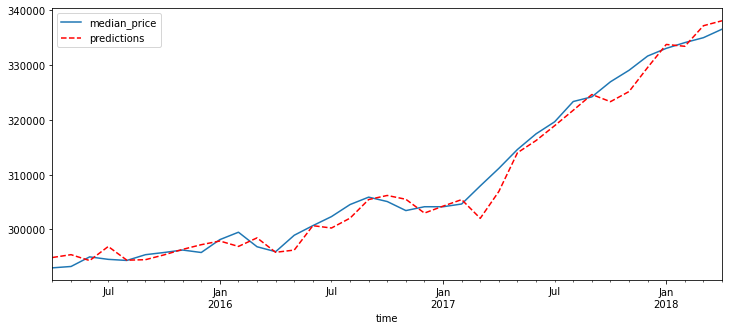

In [429]:
# walk-forward validation
predictions=[]
history = [x for x in train.values]
actuals = test.values

for t in range(len(test)):
    results = train_sarimax(history, pdq=(1,1,1), PDQS=(1,1,1,12), summary=False)
    output=results.forecast()
    y_hat = output[0]
    predictions.append(y_hat)
    actual = actuals[t]
    history.append(actual)
    #print('predicted: {}, expected: {}'.format(y_hat, actual))

predictions = pd.Series(predictions, index=test.index)

rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f'Test RMSE: {rmse}')

fig,ax=plt.subplots(figsize=(12,5))
test.plot(ax=ax, label='actuals')
predictions.plot(ax=ax, style='r--', label='predictions')
legend=ax.legend(loc='lower right')
plt.legend()

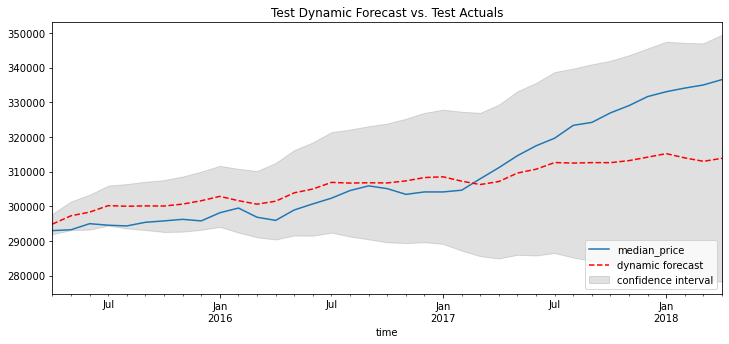

RMSE: 9400.345050242297


9400.345050242297

In [447]:
# dynamic prediction 
results = train_sarimax(train, pdq=(1,1,1), PDQS=(1,1,1,12), summary=False)
test_dynamic_predictions(results, test)
# pred = results.get_prediction(start=test.index[0], end=pd.to_datetime('2018-04-01'), dynamic=True)
# pred_ci = pred.conf_int()

# plt.figure(figsize=(12,5))
# plt.plot(train['2014-01-01':], label='training')
# plt.plot(test, label='test')
# plt.plot(pred.predicted_mean, label='forecast')
# plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')

# plt.title('Forecast vs. Actuals')
# plt.legend()
# plt.show()

# y_forecasted = pred.predicted_mean
# print(f'RMSE: {np.sqrt(mean_squared_error(y_forecasted, test))}')

In [59]:
# Notice the points fall along a line in the middle of the graph, 
# but curve off in the extremities. Normal Q-Q plots that exhibit this 
# behavior usually mean your data have more extreme values than would be expected if they truly came from a Normal distribution.
# https://data.library.virginia.edu/understanding-q-q-plots/


In [90]:
# TODO make predictions using differenced data vs non differenced data 